In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv("creditcard.csv")

In [3]:
df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [93]:
df["Class"].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [7]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [8]:
len(df_train), len(df_val), len(df_test)

(170883, 56962, 56962)

In [9]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [10]:
y_train = df_train.Class.values
y_val = df_val.Class.values
y_test = df_test.Class.values

df_train_neg = df_train.query("Class == 0")
df_val_neg = df_val.query("Class == 0")
df_test_neg = df_test.query("Class == 0")

df_train_pos = df_train.query("Class == 1")
df_val_pos = df_val.query("Class == 1")
df_test_pos = df_test.query("Class == 1")

In [11]:
y_train.sum(), len(y_train), round(y_train.sum() / len(y_train),5), \
y_val.sum(), len(y_val), round(y_val.sum() / len(y_val),5), \
y_test.sum(), len(y_test), round(y_test.sum() / len(y_test),5)

(308, 170883, 0.0018, 97, 56962, 0.0017, 87, 56962, 0.00153)

In [74]:
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
import xgboost as xgb
from sklearn.metrics import recall_score, precision_score

def convert_and_train(df_train_us, df_val_us, y_train_us, y_val_us):
    dv = DictVectorizer(sparse=False)
    
    train_dict = df_train_us.to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    val_dict = df_val_us.to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    features = dv.get_feature_names()
    dtrain = xgb.DMatrix(X_train, label=y_train_us, feature_names=features)
    dval = xgb.DMatrix(X_val, label=y_val_us, feature_names=features)
    
    xgb_params = {
        'eta': 0.3, 
        'max_depth': 6,
        'min_child_weight': 1,

        'objective': 'binary:logistic',
        'nthread': 8,

        'seed': 1,
        'verbosity': 1,
    }

    model = xgb.train(xgb_params, dtrain, num_boost_round=10)
    
    y_pred = model.predict(dval)
    y_label = y_pred > 0.5
    
    return roc_auc_score(y_val_us, y_pred), recall_score(y_val_us, y_label), precision_score(y_val_us, y_label)

In [80]:
# percentages = [0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4, 1]
percentages = np.linspace(0.1, 1, num=20)
roc_scores = []
recall_scores = []
precision_scores = []

for pct in percentages :
    pos_class = y_train.sum()
    neg_class = round(pos_class / pct)
    df_neg_sample = df_train_neg.sample(neg_class, random_state=1) #undersample
    df_train_us = df_train_pos.append(df_neg_sample, ignore_index=True)
    
    pos_class = y_val.sum()
    neg_class = round(pos_class / pct)
    df_neg_sample = df_val_neg.sample(neg_class, random_state=1) #undersample
    df_val_us = df_val_pos.append(df_neg_sample, ignore_index=True)
    
    pos_class = y_test.sum()
    neg_class = round(pos_class / pct)
    df_neg_sample = df_test_neg.sample(neg_class, random_state=1) #undersample
    df_test_us = df_test_pos.append(df_neg_sample, ignore_index=True)
    
    y_train_us = df_train_us.Class.values
    y_val_us = df_val_us.Class.values
    y_test_us = df_test_us.Class.values

    del df_train_us['Class']
    del df_val_us['Class']
    del df_test_us['Class']
    
    roc, recall, precision = convert_and_train(df_train_us, df_val_us, y_train_us, y_val_us)
    roc_scores.append(roc)
    precision_scores.append(precision)
    recall_scores.append(recall)

/opt/anaconda3/envs/general/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/general/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/general/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/general/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarni

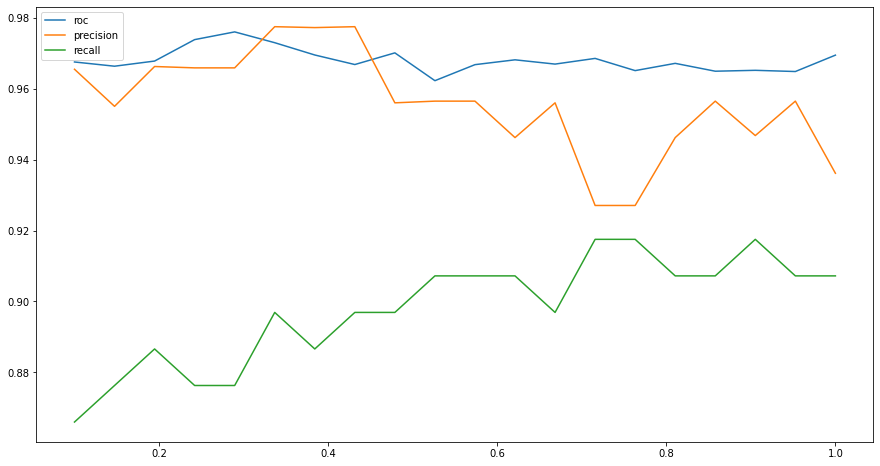

In [92]:
plt.figure(figsize=(15,8))

plt.plot(percentages, roc_scores, label="roc")
plt.plot(percentages, precision_scores, label="precision") 
plt.plot(percentages, recall_scores, label="recall")
plt.legend()
plt.show()

In [94]:
plt.savefig("target-rate-result.png")

<Figure size 432x288 with 0 Axes>